## Introduction

This blog post is a continuation of [my previous post on R2D2 priors for GLMMs](../2025-12-08_r2d2_glmm/index.qmd), where I shared some notes from reading the paper.

The goal is to replicate the example in Section 4.1 in which the authors use the R2D2 prior in
a mixed-effects logistic regression model applied to the `gambia` dataset from the `{geoR}` package in R.

First, I implement the model in PyMC and obtain results similar to those reported in the paper and then,
I show how alternative priors and a different parameterization can make inference faster, more stable, and less uncertain.

Without further ado, let's get into it.

In [1]:
#| code-fold: true
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pymc as pm
import xarray as xr

from scipy import special

from utils import WGBP, LogisticFamily

random_seed = sum(map(ord, "gambia"))


def compute_conditional_R2(pi):
    mu_var = pi.var("__obs__")
    var_mean = (pi * (1 - pi)).mean("__obs__")
    return mu_var / (mu_var + var_mean)


def plot_priors(ds, var_names, axes):
    for ax, var_name in zip(axes, var_names):
        var_dims = ds[var_name].dims

        if len(var_dims) > 2:
            dim_name = var_dims[-1]
            for i, (_, arr) in enumerate(ds[var_name].groupby(dim_name)):
                az.plot_dist(arr, color=f"C{i}", ax=ax)
        else:
            az.plot_dist(ds[var_name], ax=ax)

        ax.set(title=var_name, yticks=[])

    return axes

In [2]:
#| echo: false
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## The data

The dataset contains data related to $n = 2035$ children from $L = 65$ villages in The Gambia, Africa.
The response variable $Y_i$ (`pos`) equals 1 if child $i$ tested positive for malaria and 0 oterwise.
There are $p=5$ additional explanatory variables:

* `age`: the child's age.
* `netuse`: whether the child regularly sleeps under a bed net.
* `treated`: whether the bed net was treated.
* `green`: a measure of vegetation greenness in the immediate vecinity of the village.
* `phc`: whether the village has a health center.

In [3]:
#| classes: .center-table-80
df = pl.read_csv("gambia.csv")
df_locations = (
    df.select("x", "y")
    .unique(maintain_order=True)
    .with_columns(location=pl.row_index())
)
df = df.join(df_locations, on=["x", "y"])
df

x,y,pos,age,netuse,treated,green,phc,location
f64,i64,i64,i64,i64,i64,f64,i64,u32
349631.3,1458055,1,1783,0,0,40.85,1,0
349631.3,1458055,0,404,1,0,40.85,1,0
349631.3,1458055,0,452,1,0,40.85,1,0
349631.3,1458055,1,566,1,0,40.85,1,0
349631.3,1458055,0,598,1,0,40.85,1,0
…,…,…,…,…,…,…,…,…
622086.1,1474011,1,1705,1,0,50.1,1,64
622086.1,1474011,1,1704,1,0,50.1,1,64
622086.1,1474011,1,1733,0,0,50.1,1,64


The `{geoR}` package also includes the border data for The Gambia, which we use to create the following visualization:

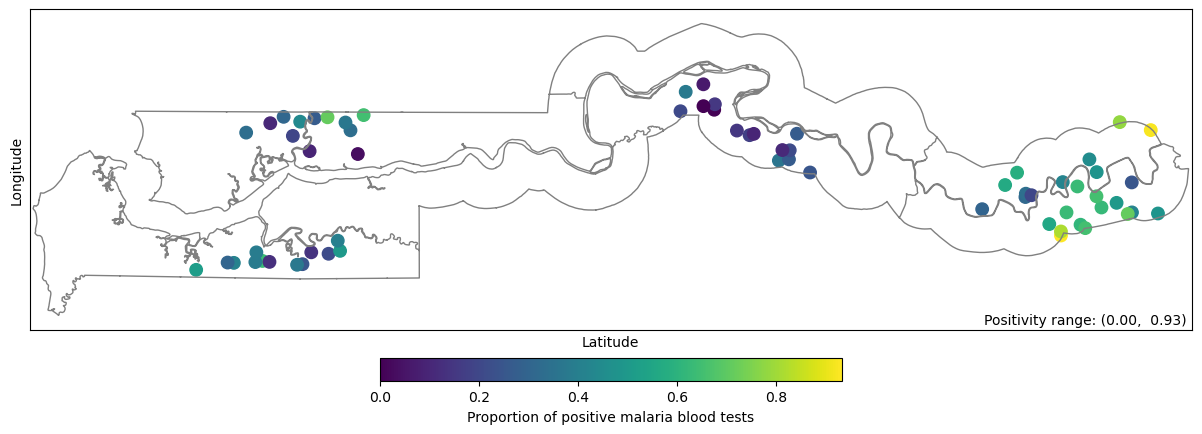

In [4]:
#| code-fold: true
#| label: fig-map
#| fig-cap: "Proportion of positive tests per village in The Gambia, Africa."
df_borders = pl.read_csv("gambia_borders.csv")

df_avg = (
    df.group_by("location")
    .agg(
        pl.col("pos").mean(),
        pl.col("x").first(),
        pl.col("y").first()
    )
)

fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df_borders["x"], df_borders["y"], color="0.5", lw=1)
points = ax.scatter(
    df_avg["x"],
    df_avg["y"],
    s=80,
    c=df_avg["pos"],
    cmap="viridis"
)

fig.colorbar(
    points,
    label="Proportion of positive malaria blood tests",
    ax=ax,
    pad=0.06,
    fraction=0.05,
    aspect=20,
    orientation="horizontal",
)
ax.set(
    aspect="equal",
    xlim=(df_borders["x"].min() - 1000, df_borders["x"].max() + 1000),
    xticks=[],
    yticks=[],
    xlabel="Latitude",
    ylabel="Longitude",
)

ax.text(
    x=0.995,
    y=0.01,
    s=f"Positivity range: ({df_avg['pos'].min():.2f}, {df_avg['pos'].max(): .2f})",
    ha="right",
    va="bottom",
    transform=ax.transAxes,
);

@fig-map shows that positivity rates vary widely across villages, ranging from 0% to 93%.
There is spatial correlation in these rates: villages located near high-positivity villages tend to have higher positivity themselves,
and the same holds for low-positivity villages.
At a broader regional scale, positivity rates are highest in the eastern part of the country,
moderate in the west, and lowest in the central region.
This spatial correlation is mostly local, with nearby villages showing similar rates while villages farther apart show little or no association.

Below, we compute the distance matrix following the approach of @Yanchenko2024 and then display it.

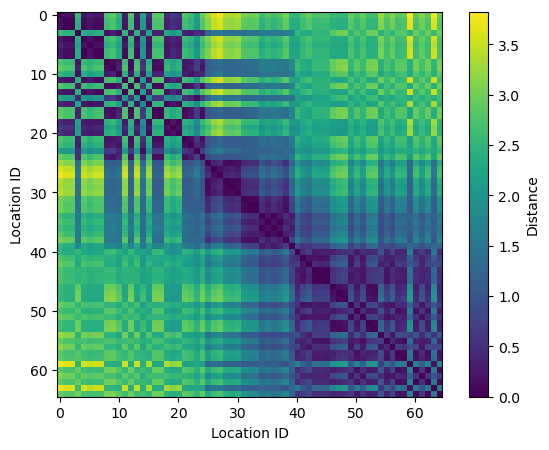

In [5]:
#| code-fold: true
def pl_scale(name):
    return (pl.col(name) - pl.col(name).mean()) / pl.col(name).std()

X_geo_std_unique = (
    df.with_columns(
        x_std=pl_scale("x"),
        y_std=pl_scale("y")
    )
    .select("x_std", "y_std")
    .unique(maintain_order=True)
    .to_numpy()
)

# Compute pairwise squared distances
diff = X_geo_std_unique[:, None, :] - X_geo_std_unique[None, :, :] # shape: (65, 65, 2)
dist = np.sqrt(np.sum(diff**2, axis=-1)) # shape: (65, 65)

fig, ax = plt.subplots(figsize=(7, 5))
img = ax.imshow(dist);

fig.colorbar(img, label="Distance", ax=ax, pad=0.05, fraction=0.045)
ax.set(xlabel="Location ID", ylabel="Location ID", aspect="equal");

## The model

The following model description is adapted from Section 4.1 in @Yanchenko2024:

$$
\begin{aligned}
Y_i \mid \pi_i &\sim \text{Bernoulli}(\pi_i) \\
\text{logit}(\pi_i) = \eta_i &= \alpha + {\bf X}_i\boldsymbol\beta+\gamma_{g[i]} \\
\alpha &\sim \text{Normal}(\mu_0, \tau_0^2) \\
\boldsymbol{\beta} &\sim \text{MVN}(0, \frac{1}{5} \phi_1 W \mathbf{I})  \\
\boldsymbol{\gamma} &\sim \text{MVN}(0, \phi_2 W \mathbf{C}) \\
C_{ij} &= \text{Cor}(\gamma_i, \gamma_j) = e^{-d_{ij} / \rho} & \text{for all } i, j  \\
\rho &\sim \text{Uniform}(0, 2r) \\
W &\sim \text{GBP}(a^*, b^*, c^*, d^*) \\
(\phi_1, \phi_2) &\sim \text{Dirichlet}(\xi_1, \xi_2)
\end{aligned}
$$

$d_{ij}$ is the (standardized) distance between villages $i$ and $j$, and $\rho > 0$ is the spatial range parameter.

For the fixed quantities, we have: $\mu_0 = 0$, $\tau_0^2 = 3$, $\xi_1 = \xi_2 = 1$, and $r$ is the maximum distance between pairs of villages.

The parameters $(a^*, b^*, c^*, d^*)$ of the GBP prior are found using the `WGBP` function
I built for [my previous blogpost](../2025-12-08_r2d2_glmm/index.qmd).
For $R^2 \sim \text{Beta}(a=1, b=1)$, we have:

In [6]:
family = LogisticFamily(a=1, b=1, intercept=special.logit(df["pos"].mean()))
params = WGBP(family)
params

array([1.36752202, 0.61766941, 0.82137832, 1.79821958])

### PyMC implementation

Before creating the model, we need one more simple data preparation step:

In [7]:
y = df.get_column("pos").to_numpy() # <1>
X = df.select("age", "netuse", "treated", "green", "phc").to_numpy() # <2>
X_std = (X - X.mean(0)) / X.std(0) # <2>
village_idx = df.get_column("location").to_numpy() # <3>
r = dist.max()  # <4>
p = X.shape[1]  # <5>

1. The vector with the observed values of $Y_i$.
2. The design matrix for the fixed effects $\mathbf{X}$, standardized.
3. The village index for each observation.
4. Maximum distance between villages.
5. Number of predictors.

And the implementation in PyMC is:

In [8]:
coords = {
    "__obs__": np.arange(len(y)),
    "predictors": ["age", "netuse", "treated", "green", "phc"],
    "village": np.unique(village_idx),
    "village_bis": np.unique(village_idx),
}

with pm.Model(coords=coords) as model:
    rho = pm.Uniform("rho", lower=0, upper=2 * r)
    C = np.exp(-dist / rho) # <1>

    V = pm.Beta("V", alpha=params[0], beta=params[1]) # <2>
    W = pm.Deterministic("W", ((V / (1 - V)) ** (1 / params[2])) * params[3]) # <2>

    phi = pm.Dirichlet("phi", a=np.ones(2))
    alpha = pm.Normal("alpha", mu=0, sigma=3 ** 0.5)
    beta = pm.Normal("beta", mu=0, sigma=((1 / p) * W * phi[0]) ** 0.5, dims="predictors") # <3>
    gamma = pm.MvNormal("gamma", mu=0, cov=phi[1] * W * C, dims="village") # <4>

    eta = alpha + X_std @ beta + gamma[village_idx]
    pi = pm.Deterministic("pi", pm.math.sigmoid(eta), dims="__obs__")

    pm.Bernoulli("y", p=pi, observed=y, dims="__obs__")

1. `C` is a matrix of shape `(65, 65)` that depends both on data (distance matrix) and a parameter (the spatial range parameter, $\rho$).
2. We use the fact that if $V \sim \text{Beta}(a^*, b^*)$, then $W = d^* (V / (1 - V))^{1/c^*} \sim \text{GBP}(a^*, b^*, c^*, d^*)$.
3. The prior on $\boldsymbol{\beta}$ uses a diagonal covariance matrix, so we can use `pm.Normal`.
4. The prior on $\boldsymbol{\gamma}$ does not, so we have to use `pm.MvNormal`.

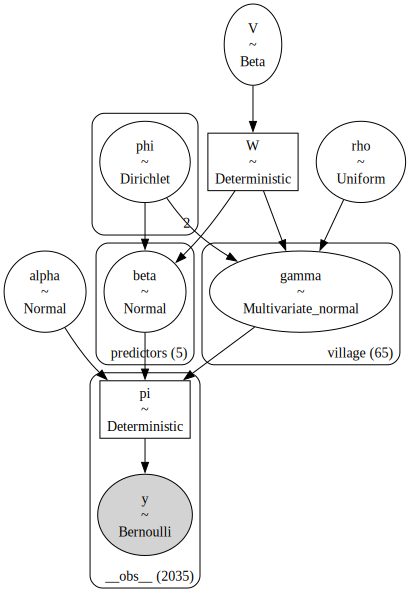

In [9]:
#| echo: false
model.to_graphviz()

The original paper obtains 10000 draws from 1 chain, here I'm going to get 10000 draws from 4 chains.
Keep in mind that while I'm using NUTS, they used a Gibbs sampler.

In [10]:
with model:
    idata = pm.sample(
        draws=2500, target_accept=0.9, random_seed=random_seed, progressbar=False
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, V, phi, alpha, beta, gamma]
Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 78 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Before diving into the traceplots, we compute the conditional bayesian $R^2$ introduced in @Gelman2019,
which is also computed and presented in the vignettes of the paper.

In [11]:
idata.posterior["R2_conditional"] = compute_conditional_R2(idata.posterior["pi"])

Looking at the traceplots, we can notice some signs of high autocorrelation and poor mixing in $\alpha$ as well as correlation between the $\gamma_i$ parameters.
On the other hand, traces for $\beta_j$ look fine.

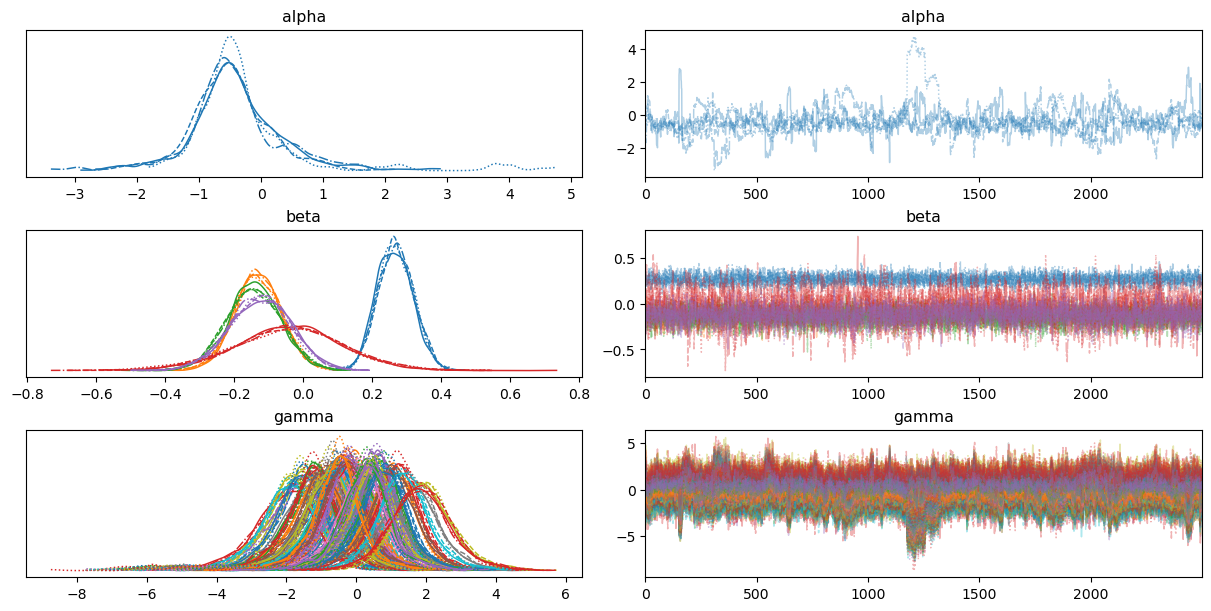

In [12]:
az.plot_trace(idata, var_names=["alpha", "beta", "gamma"], backend_kwargs={"layout": "constrained"});

Traces for $W$, $\rho$, and the conditional $R^2$ look healthy, although the marginal posterior for the first two have long tails.

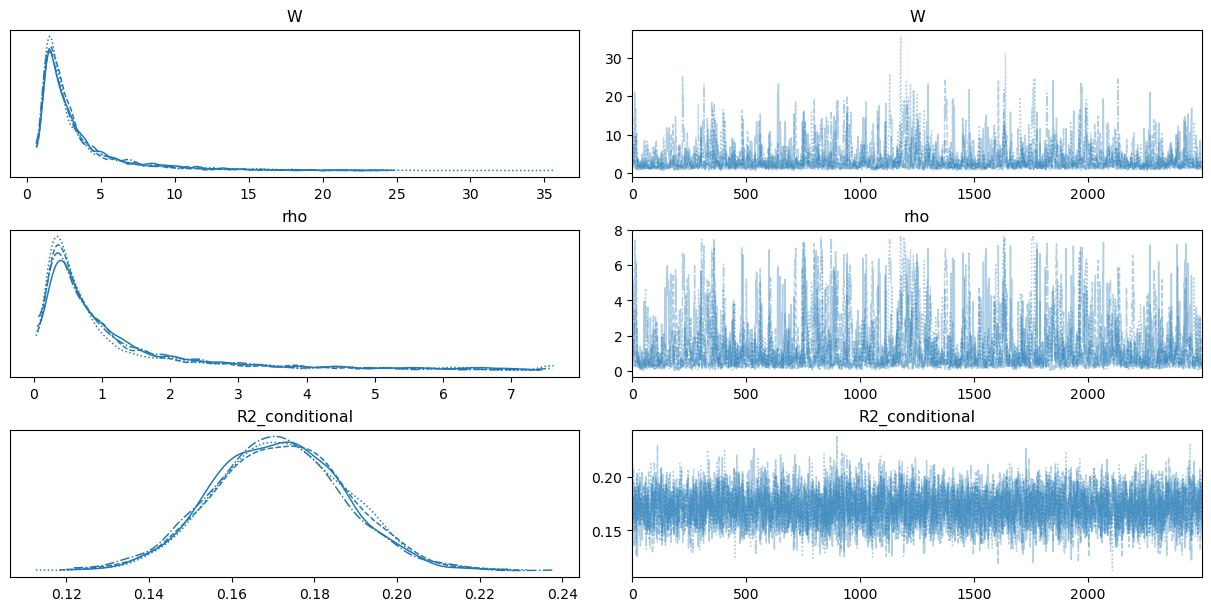

In [13]:
az.plot_trace(idata, var_names=["W", "rho", "R2_conditional"], backend_kwargs={"layout": "constrained"});

If you run the code in the [vignettes](https://github.com/eyanchenko/r2d2glmm/tree/main/vignettes),
you should find that the marginal posteriors are very similar to mine, at least by visual inspection, which allow us to conclude the implementation above is a succesful one.

### A closer look

The blog post could have finished in the previous section.
It already shows how to use the R2D2 prior for mixed-effects logistic regressions in PyMC, and the results obtained are similar to those in the paper.

However, we can take a look at a few diagnostic measures, which will help us identify areas where the model could be improved.

#### Chains don't mix well

I previously mentioned issues related to mixing and autocorrelation,
which we can confirm by inspecting the default output of `arviz.summary` applied to $\alpha$ and $\gamma_i$.

In [14]:
#| code-fold: true
#| classes: .center-table-70
pl.from_pandas(az.summary(idata, var_names=["alpha", "gamma"]).reset_index(names="param"))

param,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""alpha""",-0.392,0.794,-1.733,1.133,0.058,0.103,250.0,248.0,1.01
"""gamma[0]""",0.297,0.872,-1.396,1.722,0.058,0.094,303.0,283.0,1.01
"""gamma[1]""",-0.272,0.846,-1.769,1.216,0.059,0.098,274.0,258.0,1.01
"""gamma[2]""",-0.225,0.868,-1.802,1.268,0.06,0.096,282.0,267.0,1.01
"""gamma[3]""",-0.95,0.911,-2.615,0.609,0.059,0.091,321.0,277.0,1.01
…,…,…,…,…,…,…,…,…,…
"""gamma[60]""",0.728,0.856,-0.783,2.276,0.057,0.094,295.0,268.0,1.0
"""gamma[61]""",-0.586,0.836,-2.014,1.047,0.057,0.096,292.0,275.0,1.01
"""gamma[62]""",0.241,0.842,-1.377,1.725,0.056,0.094,296.0,272.0,1.0


The truncated output is enough to see some symptoms of poor mixing ($\hat{R} > 1$) and high autocorrelation (low ESS).

#### Priors are too wide

Have a look at marginal priors for some parameters:

Sampling: [V, alpha, beta, gamma, phi, rho, y]


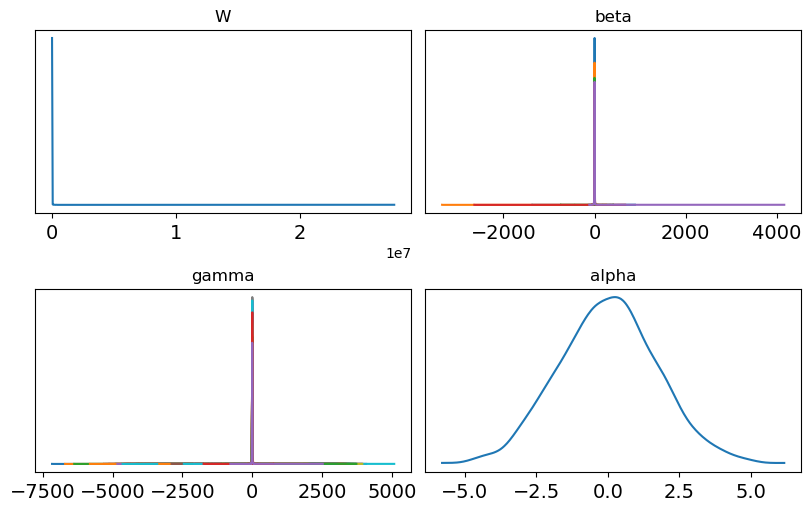

In [15]:
#| code-fold: true
#| fig-cap: Marginal prior for W, $\beta_j$, $\gamma_i$, and $\alpha$.
with model:
    idata.extend(pm.sample_prior_predictive(draws=2000, random_seed=random_seed))

fig, axes = plt.subplots(2, 2, figsize=(8, 5), layout="constrained")
plot_priors(idata.prior, ["W", "beta", "gamma", "alpha"], axes.ravel());

A flat prior on the marginal $R^2$ induces a very heavy-tailed prior on $W$,
which in turn leads to heavy-tailed priors for $\beta_j$ and $\gamma_i$.

For $\alpha$, the prior is not as heavy-tailed, but in a logistic regression context it could be made more concentrated,
as the current specification still assigns non-negligible prior mass to implausible values.

#### Correlations between $\alpha$ and $\gamma_i$ are too large

In [16]:
np.sort(xr.corr(idata.posterior.gamma, idata.posterior.alpha, dim=("chain", "draw"))).round(2)

array([-0.95, -0.95, -0.94, -0.93, -0.93, -0.93, -0.93, -0.93, -0.93,
       -0.92, -0.92, -0.92, -0.92, -0.92, -0.92, -0.92, -0.92, -0.92,
       -0.92, -0.92, -0.92, -0.91, -0.91, -0.91, -0.91, -0.91, -0.91,
       -0.91, -0.91, -0.91, -0.91, -0.9 , -0.9 , -0.9 , -0.9 , -0.9 ,
       -0.9 , -0.9 , -0.9 , -0.89, -0.89, -0.89, -0.89, -0.88, -0.88,
       -0.88, -0.88, -0.88, -0.88, -0.88, -0.88, -0.88, -0.88, -0.87,
       -0.86, -0.86, -0.85, -0.85, -0.84, -0.84, -0.83, -0.81, -0.8 ,
       -0.79, -0.76])

The correlation between $\alpha$ and each of the $\gamma_i$ is always negative and large.
Some negative correlation is expected in models with $L+1$ intercept-like parameters (a global intercept plus $L$ group effects)
but only $L$ identifiable group means: when the global intercept $\alpha$ increases,
the group-level deviations $\gamma_i$ can offset it by decreasing.

This dependence creates a narrow, tilted geometry in the posterior, which makes it harder for NUTS to explore efficiently.

#### Correlations between $\gamma_i$ and $\gamma_j$ are too large

Finally, let's have a look at the correlation between the $\gamma_i$ themselves:

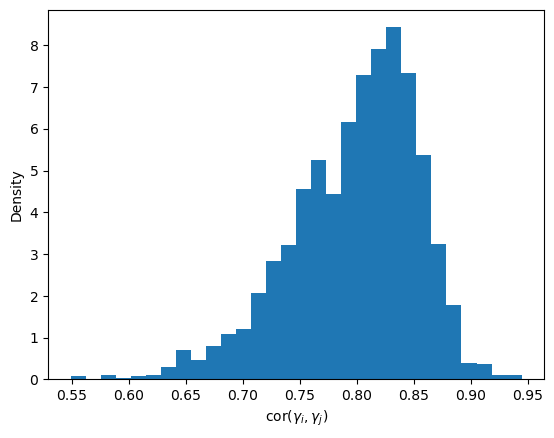

In [17]:
#| code-fold: true
corr_matrix = np.corrcoef(idata.posterior.gamma.stack(sample=("chain", "draw")).to_numpy())

idxs = np.tril_indices(corr_matrix.shape[0], k=-1)
fig, ax = plt.subplots()
ax.hist(corr_matrix[idxs], bins=30, density=True)
ax.set(xlabel="$\\text{cor}(\\gamma_i, \\gamma_j)$", ylabel="Density");

Not only is the correlation between $\alpha$ and the $\gamma_i$ large in magnitude,
but the $\gamma_i$ are also highly correlated with one another.
Here these correlations are all positive.
As before, this strong dependence makes the posterior geometry more difficult, so NUTS has a harder time exploring it efficiently.

A quick way to assess how much redundancy there is among parameters is to look at the eigenvalues of the correlation matrix,
as in Principal Component Analysis.
The ratio between the eigenvalues and the number of variables indicates the fraction of the total variability that is captured by the corresponding principal component.

In [18]:
eigenvals_1 = np.linalg.eigvals(corr_matrix)
print(eigenvals_1[:3])
print((eigenvals_1 / eigenvals_1.sum())[:3]) # n variables = sum(eigenvalues)

[52.15967642  2.12718578  0.57736294]
[0.80245656 0.03272594 0.00888251]


About 80% of the total variability in the posterior for $\boldsymbol{\gamma}$ can be captured by a single coordinate.
That's a lot of redundancy!

## An alternative proposal

I'm going to reimplement the same model, with a few tweaks:

* I'm going to use a more informative prior on the marginal $R^2$. This will result in a more sensible prior for $W$ in the context of a logistic regression model.
* I will decrease the prior variance for $\alpha$, a value of $3$ is larger than what we need in this context.
* Finally, I'm going to change the model parametrization, see details when I write the model in PyMC.

For the marginal $R^2$ I'm going to use a $\text{Beta}(2, 10)$ prior.
The resulting prior on $W$ concentrates most of the probability mass in a range that is more sensible than a $\text{Beta}(1, 1)$, 
as you can see in @fig-r2-prior.

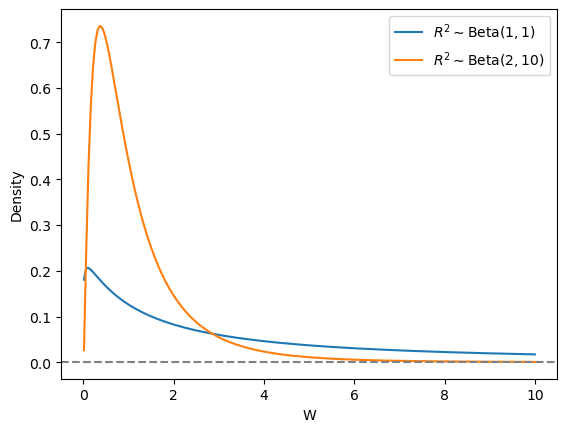

In [19]:
#| code-fold: true
#| label: fig-r2-prior
#| fig-cap: The Beta(1, 1) prior on $R^2$ induces much heavier-tailed prior on $W$ than Beta(2, 10).
from utils import gbp_pdf

family = LogisticFamily(a=2, b=10, intercept=special.logit(df["pos"].mean()))
params_2 = WGBP(family)

params_dict = {
    "$R^2 \\sim \\text{Beta}(1, 1)$": params,
    "$R^2 \\sim \\text{Beta}(2, 10)$": params_2,
}

fig, ax = plt.subplots()
x_grid = np.linspace(0.01, 10, num=200)

for key, values in params_dict.items():
    ax.plot(x_grid, gbp_pdf(x_grid, *values), label=key)

ax.axhline(0, ls="--", color="0.5")
ax.set(xlabel="W", ylabel="Density")
ax.legend();

The implementation in PyMC looks almost exactly the same:

In [20]:
with pm.Model(coords=coords) as model_2:
    rho = pm.Uniform("rho", lower=0, upper=2 * r)
    C = np.exp(-dist / rho)

    V = pm.Beta("V", alpha=params_2[0], beta=params_2[1])
    W = pm.Deterministic("W", (V / (1 - V)) ** (1 / params_2[2]) * params_2[3])

    phi = pm.Dirichlet("phi", a=np.ones(2))
    alpha = pm.Normal("alpha", mu=0, sigma=0.75) # <1>
    beta = pm.Normal("beta", mu=0, sigma=(1 / p * W * phi[0]) ** 0.5, dims="predictors")
    gamma = pm.MvNormal("gamma", mu=alpha, cov=phi[1] * W * C, dims="village") # <2>

    eta = X_std @ beta + gamma[village_idx]
    pi = pm.Deterministic("pi", pm.math.sigmoid(eta), dims="__obs__")

    pm.Bernoulli("y", p=pi, observed=y, dims="__obs__")

1. The prior standard deviation of $\alpha$ is now 0.75, instead of $\sqrt{3}$.
2. Change the parameterization for $\boldsymbol{\gamma}$. 
I center the prior for $\gamma_i$ directly around $\alpha$, instead of centering them around 0
and then computing $\alpha + \gamma_i$.

Before doing inference, let's check the prior:

Sampling: [V, alpha, beta, gamma, phi, rho, y]


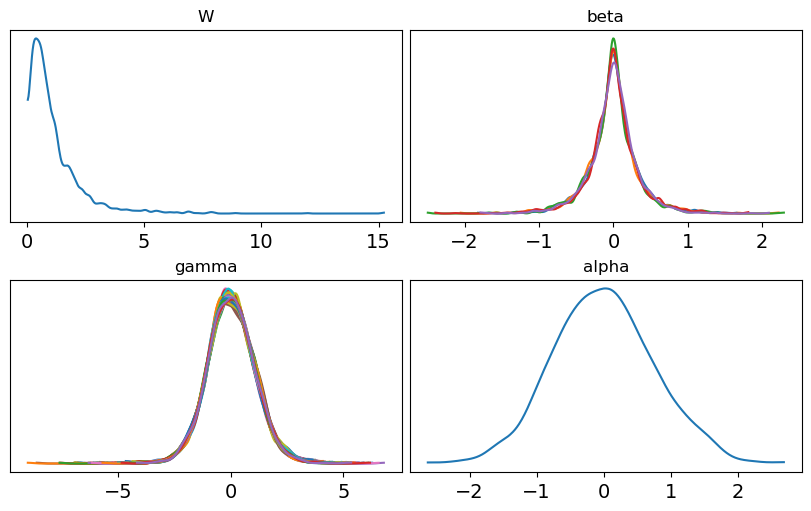

In [21]:
#| code-fold: true
with model_2:
    idata_2 = pm.sample_prior_predictive(draws=2000, random_seed=random_seed)

fig, axes = plt.subplots(2, 2, figsize=(8, 5), layout="constrained")
plot_priors(idata_2.prior, ["W", "beta", "gamma", "alpha"], axes.ravel());

If we look at the marginal priors of the parameters we inspected before, we can see they span a more reasonable range now.
The marginal priors for the $\gamma_i$ are still a bit too wide, but they are not as heavy-tailed as before.

Next, we get 1000 draws across four chains using NUTS. Sampling is faster than before and completes without warnings.

In [22]:
#| code-fold: true
with model_2:
    idata_2.extend(pm.sample(target_accept=0.9, random_seed=random_seed, progressbar=False))

idata_2.posterior["R2_conditional"] = compute_conditional_R2(idata_2.posterior["pi"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, V, phi, alpha, beta, gamma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


All the traces look healthier than before:

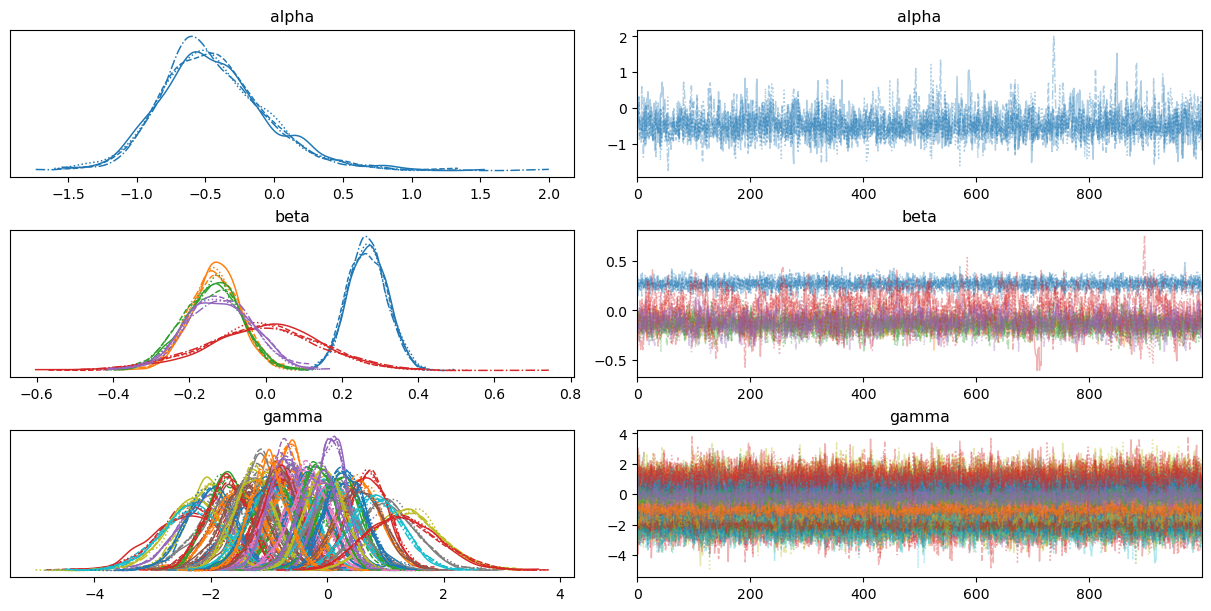

In [23]:
az.plot_trace(idata_2, var_names=["alpha", "beta", "gamma"], backend_kwargs={"layout": "constrained"});

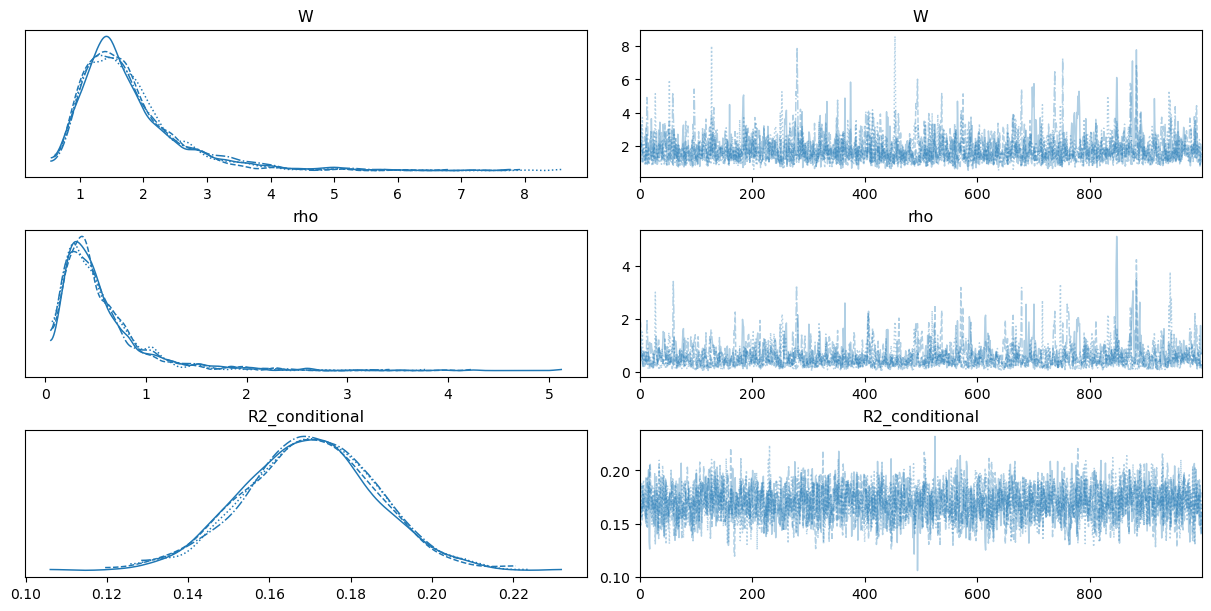

In [24]:
az.plot_trace(idata_2, var_names=["W", "rho", "R2_conditional"], backend_kwargs={"layout": "constrained"});

If we inspect the correlation between the global intercept $\alpha$ and the group-level deviations $\gamma_i$, they look much better now:

In [25]:
np.sort(xr.corr(idata_2.posterior.gamma, idata_2.posterior.alpha, dim=("chain", "draw"))).round(3)

array([-0.101, -0.099, -0.099, -0.09 , -0.076, -0.072, -0.071, -0.046,
       -0.045, -0.044, -0.043, -0.037, -0.036, -0.034, -0.026, -0.019,
       -0.018, -0.016, -0.015, -0.013, -0.012, -0.011, -0.008, -0.005,
       -0.003, -0.002, -0.002,  0.002,  0.003,  0.01 ,  0.011,  0.014,
        0.015,  0.017,  0.018,  0.019,  0.02 ,  0.022,  0.025,  0.033,
        0.04 ,  0.05 ,  0.053,  0.055,  0.059,  0.059,  0.06 ,  0.061,
        0.064,  0.064,  0.067,  0.071,  0.073,  0.073,  0.075,  0.077,
        0.077,  0.082,  0.084,  0.097,  0.097,  0.1  ,  0.104,  0.108,
        0.125])

Something similar applies to the correlation between the $\gamma_i$ themselves.
While not all correlations are negligible in magnitude, their distribution is now centered around zero.

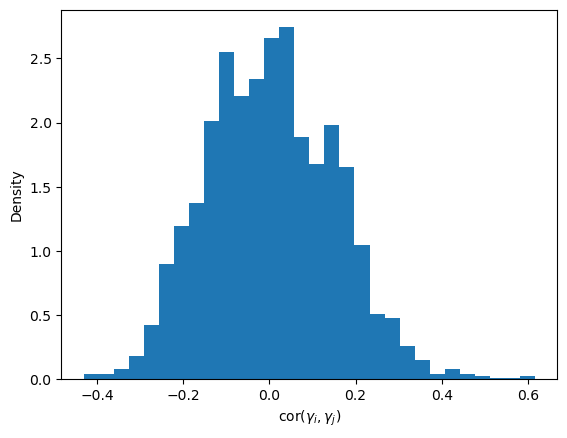

In [26]:
#| code-fold: true
corr_matrix = np.corrcoef(idata_2.posterior.gamma.stack(sample=("chain", "draw")).to_numpy())
idxs = np.tril_indices(corr_matrix.shape[0], k=-1)
fig, ax = plt.subplots()
ax.hist(corr_matrix[idxs], bins=30, density=True)
ax.set(xlabel="$\\text{cor}(\\gamma_i, \\gamma_j)$", ylabel="Density");

Looking at the eigenvalues, the share of variability captured by the first dimension drops from 80% to 15%, indicating that the correlations within $\boldsymbol{\gamma}$ have decreased substantially.

In [27]:
eigenvals_2 = np.linalg.eigvals(corr_matrix)
print(eigenvals_2[:3])
print((eigenvals_2 / eigenvals_2.sum())[:3]) # n variables = sum(eigenvalues)

[9.89843255 2.38709994 2.14716362]
[0.15228358 0.03672461 0.03303329]


All in all, posterior geometry seems nicer to NUTS.

## Some comparisons

A question I had after rewriting the model with some changes was: how does this affect the posterior?

Let's compare some (marginal) posteriors between the two models. I'm going to start with $\alpha$ and $\beta_j$.

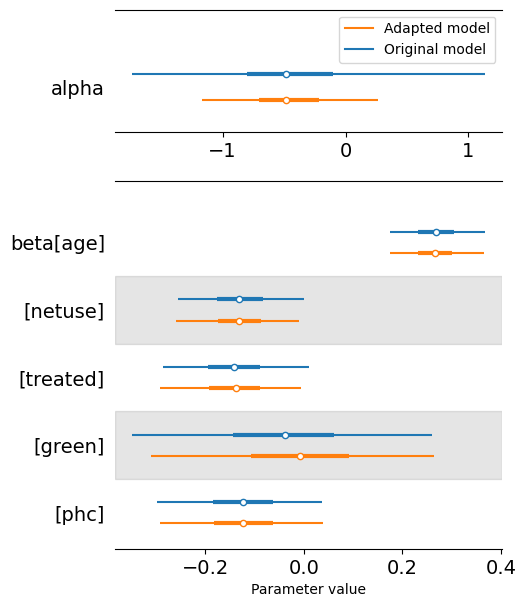

In [ ]:
#| code-fold: true
fig, axes = plt.subplots(2, 1, figsize=(5, 7), gridspec_kw={"height_ratios": [1, 3]})

az.plot_forest(
    [idata, idata_2], 
    var_names="alpha",
    combined=True,
    model_names=["Original model", "Adapted model"],
    ax=axes[0]
)
az.plot_forest(
    [idata, idata_2],
    var_names="beta",
    combined=True,
    ax=axes[1]
);

axes[0].set(title=None)
axes[1].set(title=None, xlabel="Parameter value")
axes[1].get_legend().remove();

In both cases, the posterior for $\alpha$ is centered at essentially the same value,but the adapted model produces a more concentrated distribution.
This is expected since we used a more informative prior for $\alpha$ and reduced its posterior correlation with $\boldsymbol{\gamma}$.
For $\beta_j$, they look the same.

Let's have a look at a few $\gamma_i$:

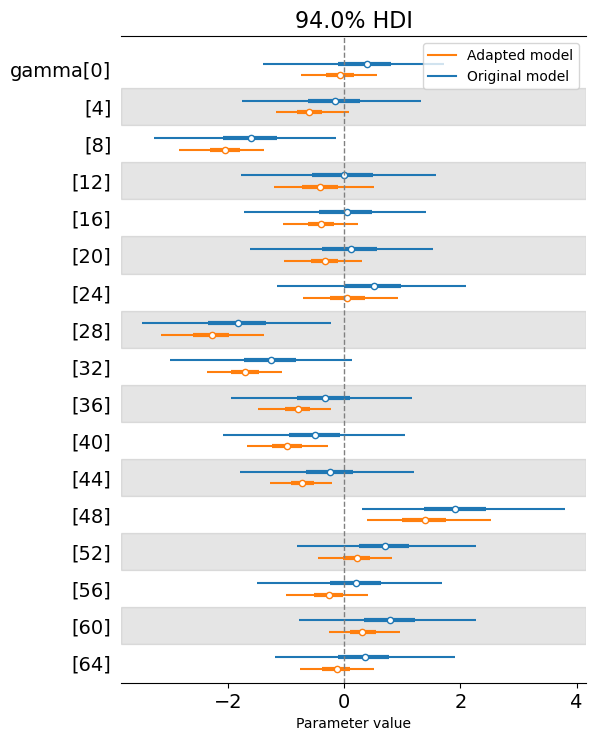

In [ ]:
#| code-fold: true
ax = az.plot_forest(
    [idata, idata_2],
    var_names="gamma",
    combined=True,
    model_names=["Original model", "Adapted model"],
    coords={"village": np.arange(0, 65, step=4)}
)
ax[0].axvline(0, color="0.5", lw=1, ls="--")
ax[0].set(xlabel="Parameter value");

In some cases, the marginal posterior for $\gamma_i$ is closer to 0.
In others, it is farther away.
But in every case, the adapted model produces a more concentrated posterior, indicating reduced uncertainty.

To wrap up, let’s compare the posterior distribution of the conditional $R^2$ under the two models:

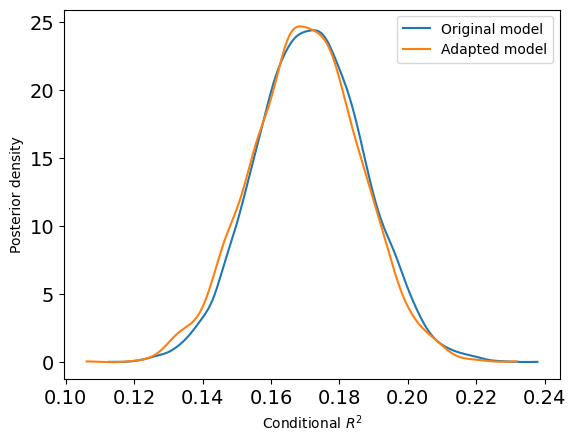

In [31]:
#| code-fold: true
ax = az.plot_dist(idata.posterior["R2_conditional"], label="Original model")
az.plot_dist(idata_2.posterior["R2_conditional"], label="Adapted model", color="C1", ax=ax)
ax.set(xlabel="Conditional $R^2$", ylabel="Posterior density");

They are essentially identical: the changes to the priors and parameterization do not affect the posterior distribution of the conditional $R^2$.

## What's next

With this post, I returned to the example where I started. It's been quite a ride.
I think this is the most challenging of the examples in @Yanchenko2024.

Next, I'll publish another post reproducing the remaining examples, where $W$ has a closed-form solution.
But that will have to wait until next year. Now, it's time to go on vacation.